In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pytorch_lightning as pl
import wandb
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchmetrics.regression import R2Score
from PIL import Image
import timm
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

## Dataframe preprocessing

In [2]:
# Get the dataframe/
df = pd.read_csv('/kaggle/input/planttraits2024/train.csv')
test_df = pd.read_csv('/kaggle/input/planttraits2024/test.csv')

In [3]:
print(len(df))
print(len(test_df))

55489
12746


In [4]:
a = len(df)
# Remove outliers
df = df[(df['X4_mean'] <0.9206089075) &
                        (df['X11_mean'] < 50.8005308717442) & 
                        (df['X18_mean'] < 28.5236956466667) & 
                        (df['X50_mean'] < 4.46409638322222) & 
                        (df['X26_mean'] < 1395.93295633333) &                            
                        (df['X3112_mean'] < 24518.4214958333
)]
b = len(df)

print(a, b,  b/a)

# Define the target columns
target_cols = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
# Define the columns to be droppped
drop_cols = ['id', 'X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd']


# Create the image_path column
train_image_dir = '/kaggle/input/planttraits2024/train_images/'
test_image_dir = '/kaggle/input/planttraits2024/test_images/'
df['image_paths'] = df['id'].apply(lambda x: train_image_dir+str(x)+'.jpeg')
test_df['image_paths'] = test_df['id'].apply(lambda x: test_image_dir+str(x)+'.jpeg')


# Drop columns
df = df.drop(columns = drop_cols, axis=1)

55489 52617 0.9482419939087027


In [5]:
# Scale all the independent features in df and test_df

# Separate independent features and target columns
X_train = df.drop(columns=target_cols + ['image_paths'])
X_test = test_df.drop(columns=['image_paths', 'id'])

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Create new DataFrames with the scaled features
df_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
test_df_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Concatenate the scaled features with target columns and image_paths
df_scaled = pd.concat([df_scaled, df[target_cols + ['image_paths']]], axis=1)
test_df_scaled = pd.concat([test_df_scaled, test_df[['image_paths', 'id']]], axis=1)

In [6]:
df_scaled = df_scaled.dropna()

In [7]:
df_scaled.head()

,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean,image_paths
0,-0.287751,-0.887309,-0.547969,0.492597,0.789925,0.865937,0.456705,0.569905,0.481742,0.626683,...,0.645169,0.547038,0.239197,0.401753,11.758108,0.117484,1.243779,1.849375,50.216034,/kaggle/input/planttraits2024/train_images/192...
1,0.376874,-1.264609,-0.938848,-0.579593,1.060791,1.603959,0.400046,0.236850,0.606498,0.498266,...,-0.790810,-0.651467,-0.493913,0.480334,15.748846,0.389315,0.642940,1.353468,574.098472,/kaggle/input/planttraits2024/train_images/195...
2,-0.021260,-0.186934,-0.644477,-1.220568,-0.430263,-0.281948,-0.563157,-0.495872,-0.578685,-0.593282,...,0.516174,0.626465,0.657305,0.796917,5.291251,8.552908,0.395241,2.343153,1130.096731,/kaggle/input/planttraits2024/train_images/196...
3,0.563038,0.572191,0.205536,-0.365734,-0.452172,-0.541820,0.173410,-0.629094,-0.204416,-0.272239,...,-0.262707,-0.220048,-0.193263,0.525236,9.568305,1.083629,0.154200,1.155308,1042.686546,/kaggle/input/planttraits2024/train_images/195...
4,-1.814059,-0.680727,-0.635375,-0.579286,2.530069,2.248820,-1.469700,0.370072,-0.516307,0.177222,...,0.768205,0.619275,0.599265,0.411821,14.528877,0.657585,10.919966,2.246226,2386.467180,/kaggle/input/planttraits2024/train_images/195...


In [8]:
df_scaled.isna().sum()

WORLDCLIM_BIO1_annual_mean_temperature                                   0
WORLDCLIM_BIO12_annual_precipitation                                     0
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month    0
WORLDCLIM_BIO15_precipitation_seasonality                                0
WORLDCLIM_BIO4_temperature_seasonality                                   0
                                                                        ..
X18_mean                                                                 0
X26_mean                                                                 0
X50_mean                                                                 0
X3112_mean                                                               0
image_paths                                                              0
Length: 170, dtype: int64

In [9]:
test_df_scaled.isna().sum()

WORLDCLIM_BIO1_annual_mean_temperature                                   0
WORLDCLIM_BIO12_annual_precipitation                                     0
WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month    0
WORLDCLIM_BIO15_precipitation_seasonality                                0
WORLDCLIM_BIO4_temperature_seasonality                                   0
                                                                        ..
VOD_X_1997_2018_multiyear_mean_m10                                       0
VOD_X_1997_2018_multiyear_mean_m11                                       0
VOD_X_1997_2018_multiyear_mean_m12                                       0
image_paths                                                              0
id                                                                       0
Length: 165, dtype: int64

## Define Augmentations

In [10]:
# Define a set of augmentations for training
train_transform = A.Compose([
    A.Resize(256, 256),  # Resize images to a common size
    A.HorizontalFlip(p=0.5),  # Apply horizontal flip with a probability of 0.5
    A.VerticalFlip(p=0.5),  # Apply vertical flip with a probability of 0.5
    A.RandomRotate90(p=0.5),  # Randomly rotate the image by 90 degrees
    A.RandomBrightnessContrast(p=0.2),  # Adjust brightness and contrast
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.2),  # Randomly change hue and saturation
    A.GaussNoise(p=0.2),  # Add random Gaussian noise
    A.Normalize(),  # Normalize pixel values to be in the range [0, 1]
    ToTensorV2(),  # Convert the image to a PyTorch tensor
])

# Define augmentations for validation (usually only basic augmentations without randomness)
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2(),
])

## Define Pytorch Dataset

In [11]:
class PlantTraitsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and open the image
        img_path = self.df.iloc[idx]['image_paths']
        img = Image.open(img_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            img = self.transform(image = np.asarray(img))['image']

        # Get the corresponding row in the DataFrame and extract target columns
        target_cols = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
        targets = torch.tensor(self.df.iloc[idx][target_cols].values.astype(float), dtype=torch.float32)

        # Exclude target columns from the row
        row = torch.tensor(self.df.iloc[idx].drop(target_cols + ['image_paths']).values.astype(float), dtype=torch.float32)

        return img, row, targets

## Define Pytorch Lightning Module to train

In [12]:
from kaggle_secrets import UserSecretsClient
secret_label = "wandb-key"
secret_value = UserSecretsClient().get_secret(secret_label)

In [13]:
wandb.login(key = secret_value)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
class PlantTraitsModel(pl.LightningModule):
    def __init__(self, image_model_name, table_num_features, intermediate_num_features, num_targets, learning_rate=1e-3):
        super(PlantTraitsModel, self).__init__()

        # Image model
        self.image_model = timm.create_model(image_model_name, pretrained=True, num_classes=0)
        self.image_model_to_intermediate = torch.nn.Linear(self.image_model.num_features, intermediate_num_features)

        # Define the table model
        self.table_model = torch.nn.Sequential(
            torch.nn.Linear(table_num_features, 512),
            nn.BatchNorm1d(512),  # Batch normalization layer
            nn.Dropout(0.25),
            nn.ReLU(),
            torch.nn.Linear(512, 256),
            nn.BatchNorm1d(256),  # Batch normalization layer
            nn.Dropout(0.25),
            nn.ReLU(),
            torch.nn.Linear(256, intermediate_num_features)
        )

        # Fully connected layers with dropout and batch normalization
        self.fc_combined = nn.Sequential(
            nn.Linear(intermediate_num_features, 512),
            nn.BatchNorm1d(512),  # Batch normalization layer
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),  # Batch normalization layer
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, num_targets),
        )

        self.learning_rate = learning_rate

        # Metric for tracking R2 score
        self.r2_score = R2Score(num_outputs=6)

    def forward(self, x_image, x_table):
        x_image = self.image_model(x_image)
        x_image = self.image_model_to_intermediate(x_image)
        x_table = self.table_model(x_table)
        x_combined = (x_image + x_table)/2
        output = self.fc_combined(x_combined)
        return output
    
    def get_image_intermediate(self, x_image, x_table):
        x_image = self.image_model(x_image)
        x_image = self.image_model_to_intermediate(x_image)
        return x_image
    
    def get_table_intermediate(self, x_image, x_table):
        x_table = self.table_model(x_table)
        return x_table

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': torch.optim.lr_scheduler.OneCycleLR(
                    optimizer,
                    max_lr=self.learning_rate,
                    steps_per_epoch=len(train_dataloader),
                    epochs=self.trainer.max_epochs
                ),
                'interval': 'step',
            },
        }

    def training_step(self, batch, batch_idx):
        x_image, x_table, y_true = batch
        y_pred = self(x_image, x_table)
        loss = F.mse_loss(y_pred, y_true)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log_r2(y_pred, y_true, 'train_r2')
        return loss

    def validation_step(self, batch, batch_idx):
        x_image, x_table, y_true = batch
        y_pred = self(x_image, x_table)
        loss = F.mse_loss(y_pred, y_true)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log_r2(y_pred, y_true, 'val_r2')
        return loss

    def log_r2(self, y_pred, y_true, name):
        r2 = self.r2_score(y_pred, y_true)
        self.log(name, r2, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
    def configure_wandb_logger(self, model_name):
        # Get the current date and time in the specified format
        current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        # Generate a random 4-letter ID
        random_id = ''.join(random.choices('abcdefghijklmnopqrstuvwxyz', k=4))
        # Combine date, time, and random ID to form the run name
        run_name = f"{current_datetime}_{random_id}"
        # Initialize the WandB logger with project name and run name
        wandb_logger = pl.loggers.wandb.WandbLogger(project="PlantTraits2024", name=run_name, log_model=True)
        # Log the model name
        wandb_logger.log_hyperparams({"model_name": model_name})
        return wandb_logger


## Get the data ready

In [15]:
# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(df_scaled, test_size=0.2, random_state=32)

# Display the shapes of the resulting DataFrames
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)

Training set shape: (39909, 170)
Validation set shape: (9978, 170)


In [16]:
# Assuming df_train and df_val are your training and validation DataFrames
train_dataset = PlantTraitsDataset(df=train_df, transform=train_transform)
val_dataset = PlantTraitsDataset(df=val_df, transform=val_transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

### Sanity check on the dataloader

Training Dataloader:
Batch Size: 64
Image Size: torch.Size([64, 3, 256, 256])
Row Size: torch.Size([64, 163])
Targets Size: torch.Size([64, 6])


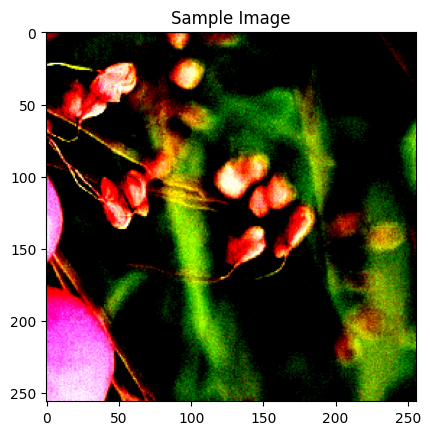

Validation Dataloader:
Batch Size: 64
Image Size: torch.Size([64, 3, 256, 256])
Row Size: torch.Size([64, 163])
Targets Size: torch.Size([64, 6])


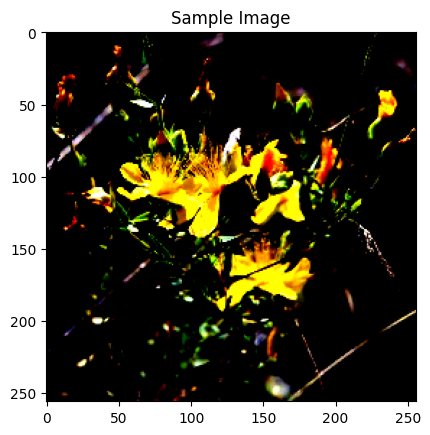

In [17]:
# Function to display batch information
def display_batch_info(batch):
    images, rows, targets = batch
    print(f"Batch Size: {len(images)}")
    print(f"Image Size: {images.size()}")
    print(f"Row Size: {rows.size()}")
    print(f"Targets Size: {targets.size()}")

    # Plot the first image in the batch
    image_np = images[0].permute(1, 2, 0).numpy()
    plt.imshow(image_np)
    plt.title("Sample Image")
    plt.show()

# Sanity check for training dataloader
train_batch = next(iter(train_dataloader))
print("Training Dataloader:")
display_batch_info(train_batch)

# Sanity check for validation dataloader
val_batch = next(iter(val_dataloader))
print("Validation Dataloader:")
display_batch_info(val_batch)

## Get the model set up

In [18]:
model = PlantTraitsModel(image_model_name="efficientnet_b2", table_num_features=163, intermediate_num_features=512, num_targets=6)

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

In [19]:
wandb_logger = model.configure_wandb_logger(model_name="efficientnet_b2")

wandb: Currently logged in as: lawjarp. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.3
wandb: Run data is saved locally in ./wandb/run-20240321_085704-7fydxhxk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run 2024-03-21_08-57-04_hywn
wandb: ⭐️ View project at https://wandb.ai/lawjarp/PlantTraits2024
wandb: 🚀 View run at https://wandb.ai/lawjarp/PlantTraits2024/runs/7fydxhxk


## Train the model

In [20]:
# Define Trainer configuration
trainer_config = {
    'max_epochs': 15,               # Specify the maximum number of epochs
    'logger': wandb_logger,         # Use WandB logger
    'precision': '16-mixed',        # Use mixed precision (16-bit)
#     'accumulate_grad_batches': 2,   # Accumulate gradients over multiple batches (if needed)
    'check_val_every_n_epoch': 1,   # Validate every epoch
    'callbacks': [
        # Add any additional callbacks if needed
        pl.callbacks.LearningRateMonitor(logging_interval='step'),  # Log learning rate
        pl.callbacks.ModelCheckpoint(dirpath='./models/',  monitor="val_r2", mode="max", save_top_k=1),
        pl.callbacks.ModelCheckpoint(dirpath='./models/',  monitor="val_loss", mode="min", save_top_k=1)
    ],
    'benchmark': True,
}

In [21]:
# Initialize the trainer
trainer = pl.Trainer(**trainer_config)

In [22]:
# Training
trainer.fit(model, train_dataloader, val_dataloader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [23]:
print('Done')

Done


In [24]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
wandb:            lr-AdamW ▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
wandb:    train_loss_epoch ██▇▅▄▃▂▂▂▂▂▁▁▁▁
wandb:     train_loss_step ▄▃▃▄▅▄▁█▃▆▂▆▃▃▇▂▃▄▂▅▁▂▂▂▂▂▁▁▃▂▃▂▃▁▄▂▃▂▂▃
wandb:            train_r2 ▁▅▆▇▇▇█████████
wandb: trainer/global_step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:            val_loss ██▆▃▂▂▂▁▁▁▁▁▁▁▁
wandb:              val_r2 ▁▁▃▅▆▇█████████
wandb: 
wandb: Run summary:
wandb:               epoch 14
wandb:            lr-AdamW 0.0
wandb:    train_loss_epoch 984389.625
wandb:     train_loss_step 1580257.25
wandb:            train_r2 -0.05629
wandb: trainer/global_step 9359
wandb:            val_loss 1144547.0
wandb:              val_r2 -0.00922
wandb: 
wandb: 🚀 View run 2024-03-21_08-57-04_hywn at: https://wandb.ai/lawjarp/PlantTraits2024/runs/7fydxhxk
wandb: Synced 6 W&B file(

## Get Saved Model

In [25]:
# import wandb
# run = wandb.init()
# artifact = run.use_artifact('lawjarp/PlantTraits2024/model-mvl0q7ft:v0', type='model')
# artifact_dir = artifact.download()

In [26]:
# model_i = PlantTraitsModel.load_from_checkpoint('/kaggle/working/models/epoch=0-step=2767.ckpt', image_model_name="efficientnet_b2", table_num_features=163, intermediate_num_features=1024, num_targets=6)

In [27]:
model_for_inference = model.to('cuda')

# model_for_inference = model_i.to('cuda')

In [28]:
import tqdm 

device = 'cuda'

# Define the same transformations used for validation
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2(),
])

# Define your dataset class for the test set
class TestPlantTraitsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and open the image
        img_path = self.df.iloc[idx]['image_paths']
        img = Image.open(img_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            img = self.transform(image = np.asarray(img))['image']

        # Exclude target columns from the row
        row = torch.tensor(self.df.iloc[idx].drop(['image_paths', 'id']).values.astype(float), dtype=torch.float32)

        return img, row

# Create an instance of the TestPlantTraitsDataset
test_dataset = TestPlantTraitsDataset(df=test_df_scaled, transform=test_transform)

# Use a DataLoader for batch processing
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Set the model to evaluation mode
model_for_inference.eval()

# List to store predictions
all_predictions = []

# Iterate through the test dataloader
for batch in tqdm.tqdm(test_dataloader):
    # Unpack the batch
    images, rows = batch

    # Move data to the device
    images = images.to(device)
    rows = rows.to(device)

    # Make predictions
    with torch.no_grad():
        predictions = model_for_inference(images, rows)

    # Move predictions back to CPU if necessary
    predictions = predictions.cpu().numpy()

    # Append predictions to the list
    all_predictions.append(predictions)

# Concatenate predictions from all batches
all_predictions = np.concatenate(all_predictions, axis=0)

# Create a DataFrame with the predictions and corresponding IDs
submission_df = pd.DataFrame({
    'id': test_df['id'].values,
    'X4': all_predictions[:, 0],
    'X11': all_predictions[:, 1],
    'X18': all_predictions[:, 2],
    'X50': all_predictions[:, 4],
    'X26': all_predictions[:, 3],
    'X3112': all_predictions[:, 5],
})

100%|██████████| 797/797 [01:12<00:00, 11.02it/s]


In [29]:
submission_df.head()

,id,X4,X11,X18,X50,X26,X3112
0,195066138,0.517633,11.512035,2.574507,1.589609,25.829708,1292.055176
1,195524180,0.497491,12.400314,0.928176,1.600766,8.969863,541.896790
2,172220512,0.529893,14.523545,3.818253,1.592116,41.877136,2066.342041
3,195824490,0.503783,11.590051,1.552821,1.599856,15.476048,841.053650
4,191793047,0.524300,12.919790,3.040736,1.593368,30.545404,1527.033203


In [30]:
submission_df.to_csv('submission.csv', index=False)